In [1]:
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer


# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [2]:
papers = pd.read_csv("NIPS_paper/papers.csv")
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [3]:
#statistical summary of the paper
papers.describe(include='all')

,id,year,title,event_type,pdf_name,abstract,paper_text
count,7241.000000,7241.000000,7241,2422,7241,7241,7241
unique,NaN,NaN,7241,3,7241,3923,7237
top,NaN,NaN,A Small World Threshold for Economic Network F...,Poster,922-pca-pyramids-for-image-compression.pdf,Abstract Missing,Launch and Iterate: Reducing Prediction Churn\...
freq,NaN,NaN,1,2146,1,3317,2
mean,3655.912167,2006.439718,NaN,NaN,NaN,NaN,NaN
std,2098.435219,8.759919,NaN,NaN,NaN,NaN,NaN
min,1.000000,1987.000000,NaN,NaN,NaN,NaN,NaN
25%,1849.000000,2000.000000,NaN,NaN,NaN,NaN,NaN
50%,3659.000000,2009.000000,NaN,NaN,NaN,NaN,NaN
75%,5473.000000,2014.000000,NaN,NaN,NaN,NaN,NaN


In [4]:
## remove extraneous columns for analysis
papers.drop(columns=['id', 'event_type', 'pdf_name'], inplace=True)

Text(0.5, 1.0, 'Machine Learning Publications since 1987')

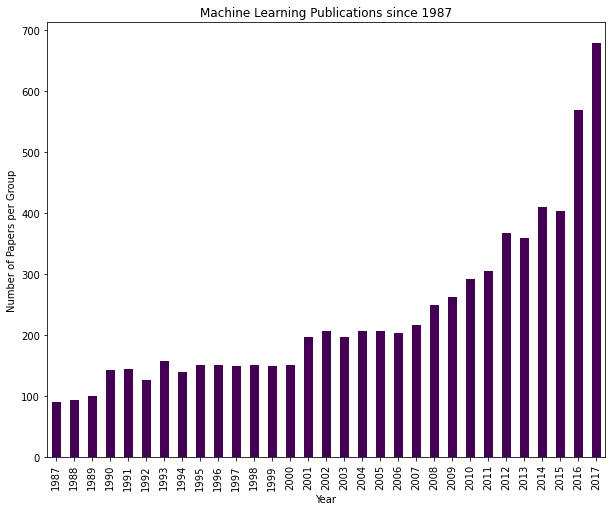

In [5]:
groups = papers.groupby('year')
counts = groups.size()

plt.figure(figsize= (10,8))
counts.plot(kind='bar', colormap='viridis')
# sns.countplot(x='year', data=papers, palette='viridis')
plt.xlabel('Year')
plt.ylabel('Number of Papers per Group')
plt.title('Machine Learning Publications since 1987')

# Data Preprocessing

In [6]:
def pre_processing(data, col):
    """
    uses regular expressions to remove punctuations in titles 
    re.sub('[,\.!?]', '', x))
    """
    # Remove punctuation
    data['title_processed'] = data[col].map(lambda x: re.sub('[,\.!?]', '', x))

    # convert words to lower case
    data['title_processed'] = data['title_processed'].map(lambda x: x.lower())

In [7]:
pre_processing(papers, 'title')

In [8]:
papers.title.sample(3)

5665                Robust k-means: a Theoretical Revisit
4829    Fast Kernel Learning for Multidimensional Patt...
2006           Bayesian Surprise Attracts Human Attention
Name: title, dtype: object

In [9]:
def create_wc(data, col):
    """ Create a wordcloud to visualizae titles"""
    long_string = " ".join(data[col])
    wc = WordCloud()
    wc.generate(long_string)
#     wc.to_image()
    return wc.to_image()

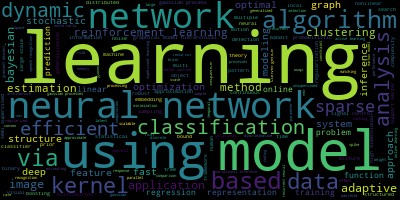

In [10]:
create_wc(papers, 'title_processed')

# Topic Modeling

In [11]:
def most_common_words(count_data, count_vectorizer):
    '''plot most common '''
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))
    plt.bar(x_pos, counts,align='center', color = 'grey')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.title('10 most common words')
    plt.show()


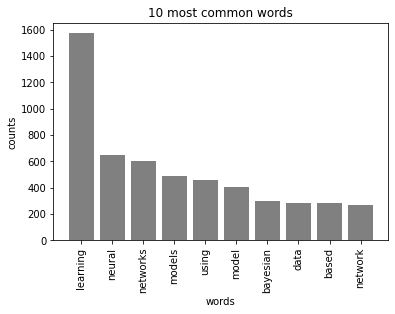

In [12]:
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(papers['title_processed'])
most_common_words(count_data, count_vectorizer)

In [13]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)

In [14]:

data = papers.title_processed.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['self', 'organization', 'of', 'associative', 'database', 'and', 'its', 'applications']]


# Build the Bigram, Trigram Models and Lemmatize

In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [18]:
# processed Text Data!
data_ready = process_words(data_words)

# Build topic

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.120*"network" + 0.087*"neural" + 0.047*"learning" + 0.021*"correlation" + '
  '0.017*"reinforcement" + 0.015*"recognition" + 0.015*"base" + '
  '0.013*"information" + 0.013*"deep" + 0.012*"system"'),
 (1,
  '0.110*"learn" + 0.040*"algorithm" + 0.023*"stochastic" + 0.018*"non" + '
  '0.018*"structure" + 0.018*"datum" + 0.016*"recurrent" + 0.014*"method" + '
  '0.014*"state" + 0.013*"optimization"'),
 (2,
  '0.042*"analysis" + 0.033*"dynamic" + 0.029*"real_time" + 0.025*"synthesis" '
  '+ 0.019*"representation" + 0.018*"linear" + 0.016*"training" + '
  '0.016*"expression" + 0.016*"interpolation" + 0.016*"application"'),
 (3,
  '0.080*"model" + 0.021*"function" + 0.015*"efficient" + 0.013*"neuron" + '
  '0.013*"backpropagation" + 0.012*"gaussian" + 0.012*"clustering" + '
  '0.012*"parallel" + 0.012*"process" + 0.011*"complexity"')]


# Dominant topic and its percentage contribution in each document

In [20]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.4420,"model, function, efficient, neuron, backpropag...","[associative, database, application]"
1,1,0.0,0.4666,"network, neural, learning, correlation, reinfo...","[mean_field, theory, layer, visual, cortex, ap..."
2,2,3.0,0.7376,"model, function, efficient, neuron, backpropag...","[store, covariance, associative, long, term, p..."
3,3,0.0,0.3308,"network, neural, learning, correlation, reinfo...","[bayesian, query, construction, neural, networ..."
4,4,0.0,0.5419,"network, neural, learning, correlation, reinfo...","[neural, network, ensemble, active, learning]"
5,5,0.0,0.5464,"network, neural, learning, correlation, reinfo...","[neural, net, instantiate, deformable, model]"
6,6,0.0,0.5601,"network, neural, learning, correlation, reinfo...","[plasticity, mediate, competitive, learning]"
7,7,0.0,0.9009,"network, neural, learning, correlation, reinfo...","[iceg, morphology, classification, analogue, v..."
8,8,2.0,0.4950,"analysis, dynamic, real_time, synthesis, repre...","[real_time, control, tokamak, plasma, neural, ..."
9,9,3.0,0.5926,"model, function, efficient, neuron, backpropag...","[pulsestream, synapsis, non, volatile, analogu..."


# The most representative sentence for each topic

In [21]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9239,"network, neural, learning, correlation, reinforcement, recognition, base, information, deep, system","[hybrid, hmm, base, speech, recognition, discriminant, neural, feature, extraction]"
1,1.0,0.9166,"learn, algorithm, stochastic, non, structure, datum, recurrent, method, state, optimization","[proximal, stochastic, method, nonsmooth, nonconvex, finite, sum, optimization]"
2,2.0,0.9107,"analysis, dynamic, real_time, synthesis, representation, linear, training, expression, interpola...","[joint, modeling, name, verb, simultaneous, face, pose, annotation]"
3,3.0,0.9206,"model, function, efficient, neuron, backpropagation, gaussian, clustering, parallel, process, co...","[spike, saturate, dendrite, differentially, expand, single, neuron, computation, capacity]"


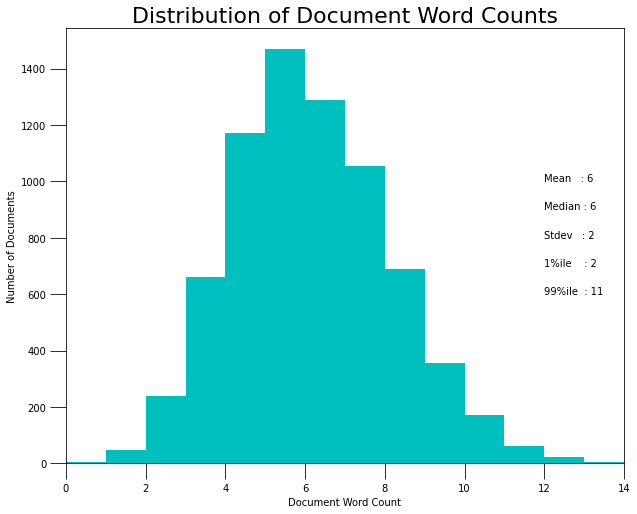

In [22]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(10,8))
plt.hist(doc_lens, bins = 15, color='c')
plt.text(12, 1000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(12, 900, "Median : " + str(round(np.median(doc_lens))))
plt.text(12, 800, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(12,  700, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(12,  600, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 14), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
# plt.xticks(np.linspace(0,15,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()


# Word Count of Topic Keywords

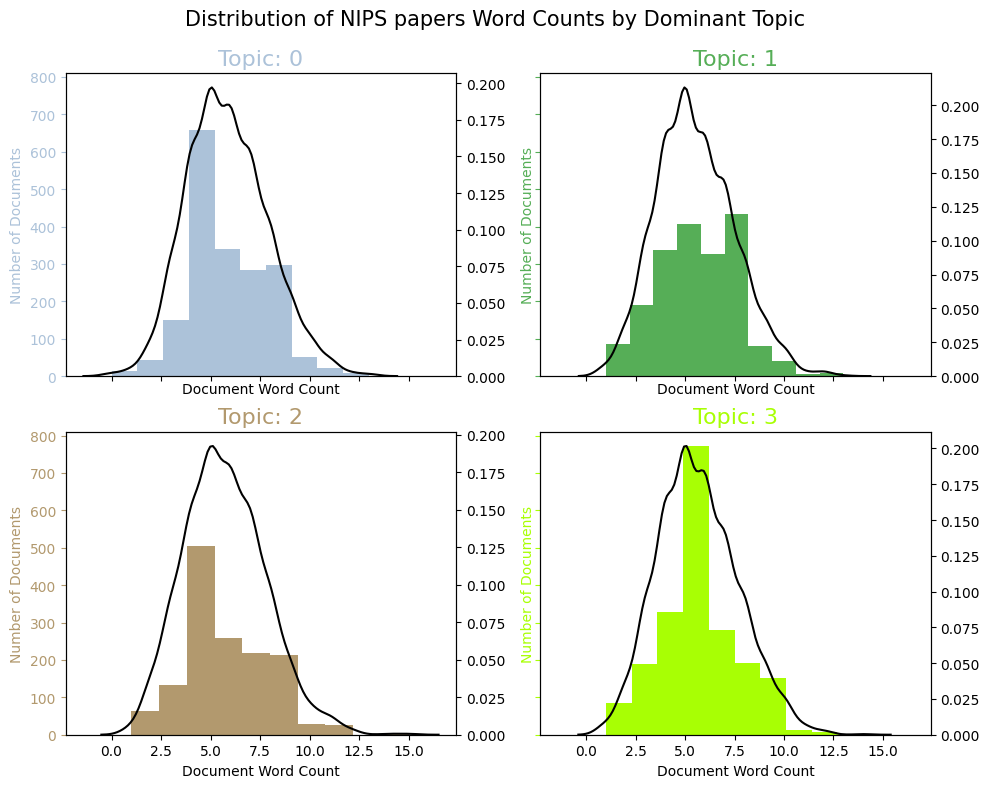

In [23]:
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.XKCD_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(10,8), dpi=100, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 10, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
# plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of NIPS papers Word Counts by Dominant Topic', fontsize=15)
plt.show()

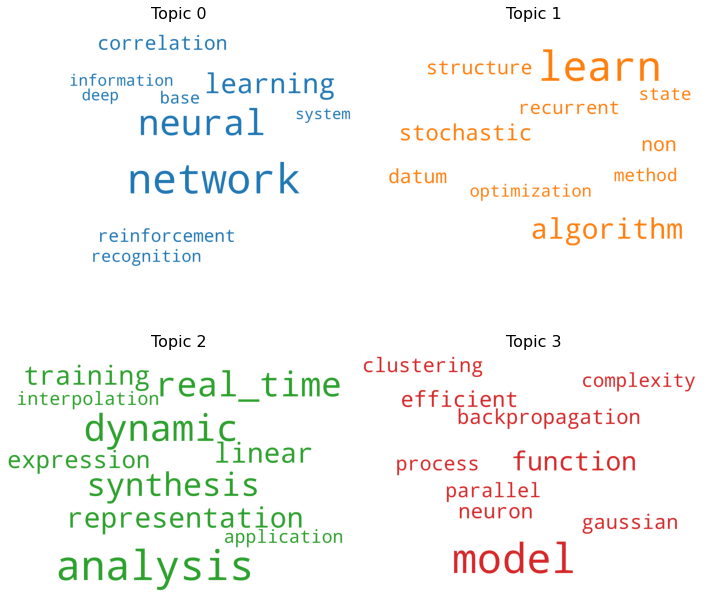

In [24]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

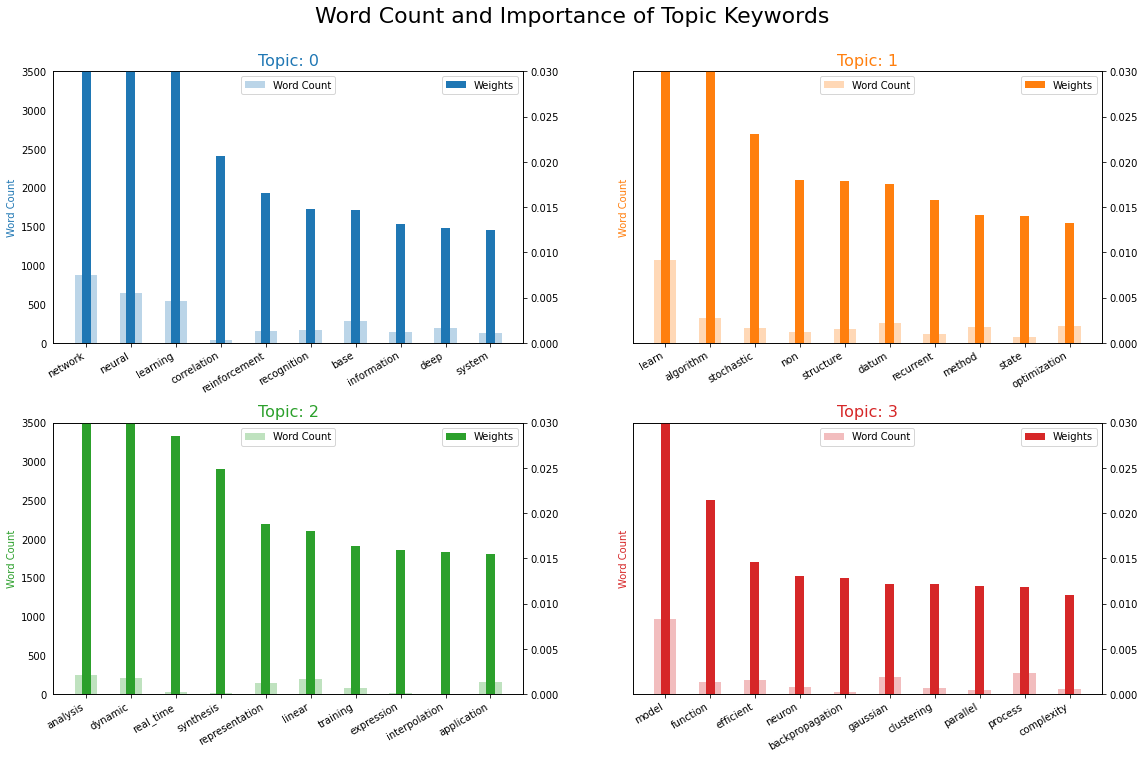

In [25]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc=9); ax_twin.legend(loc='best')

fig.tight_layout(w_pad=6)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Most discussed topics in the NIPS papers?

In [26]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)


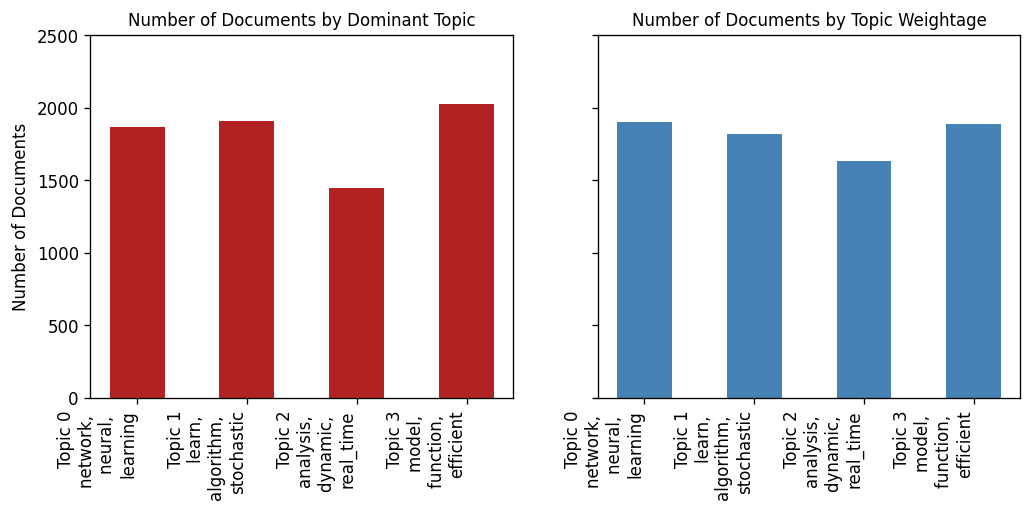

In [28]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
ax1.set_xticklabels(df_dominant_topic_in_each_doc['Dominant_Topic'], rotation=90, horizontalalignment= 'right')
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 2500)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.set_xticklabels(df_dominant_topic_in_each_doc['Dominant_Topic'], rotation=90, horizontalalignment= 'right')
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

# t-SNE Clustering Chart

In [34]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
print(mycolors)
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 6704 samples in 0.002s...
[t-SNE] Computed neighbors for 6704 samples in 0.125s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6704
[t-SNE] Computed conditional probabilities for sample 2000 / 6704
[t-SNE] Computed conditional probabilities for sample 3000 / 6704
[t-SNE] Computed conditional probabilities for sample 4000 / 6704
[t-SNE] Computed conditional probabilities for sample 5000 / 6704
[t-SNE] Computed conditional probabilities for sample 6000 / 6704
[t-SNE] Computed conditional probabilities for sample 6704 / 6704
[t-SNE] Mean sigma: 0.018325
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.048115
[t-SNE] KL divergence after 1000 iterations: 0.476957


Loading BokehJS ...

['#1f77b4' '#ff7f0e' '#2ca02c' '#d62728' '#9467bd' '#8c564b' '#e377c2'
 '#7f7f7f' '#bcbd22' '#17becf']


GlyphRenderer(id='1286', ...)

In [32]:
show(plot)

In [33]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.273275  0.139002       1        1  26.692699
3      0.061609  0.126251       2        1  25.941545
1      0.265390  0.050004       3        1  24.802092
2     -0.053724 -0.315257       4        1  22.563665, topic_info=               Term         Freq        Total Category  logprob  loglift
7           network  1318.000000  1318.000000  Default  30.0000  30.0000
51            learn  1118.000000  1118.000000  Default  29.0000  29.0000
8            neural   958.000000   958.000000  Default  28.0000  28.0000
22            model   854.000000   854.000000  Default  27.0000  27.0000
26         learning   515.000000   515.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
391       supervise    53.930882    54.788445   Topic4  -5.1476   1.4731
326           motor    54.764477    55.791679   Topic4  -5.1323   1.4702
798           study    71.281494    73.804718   Topic4  -4.8687   1.4540
1432     expression   147.980957   198.935394   Topic4  -4.1382   1.1929
721   interpolation   146.096497   228.872650   Topic4  -4.1511   1.0399

[164 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
24        2  0.990100          active
157       4  0.992235        adaptive
59        3  0.998241       algorithm
432       1  0.990040          analog
335       4  0.997591        analysis
...     ...       ...             ...
78        4  0.991532  transformation
348       1  0.977534    unsupervised
107       3  0.995618           value
821       2  0.987814     variational
10        4  0.997531          visual

[146 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])